In [1]:
### IMPORTS ###

# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import sys
import time
import copy
from tqdm.notebook import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool
import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")
##############


In [2]:
# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn


In [3]:
## Load data:
data = joblib.load('../vqe_states_job/vqe_params_0noise.job')

print('Size of Data Set: {0}'.format(len(data)))

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 100
______________________________
Size of Training Set: 80
Size of Test Set    : 20


In [4]:
N = 4
J = 1
shift_invariance = 0

In [5]:
dev_vqe_mixed   = qml.device("default.mixed", wires = N, shots = None)
@qml.qnode(dev_vqe_mixed)
def vqe_cost_fn_mixed(vqe_params, N, shift_invariance, H, p_noise = 0, p_noise_ent = 0):
    vqe.circuit(N, vqe_params, shift_invariance, p_noise, p_noise_ent)
        
    # return <psi|H|psi>
    return qml.expval(H)

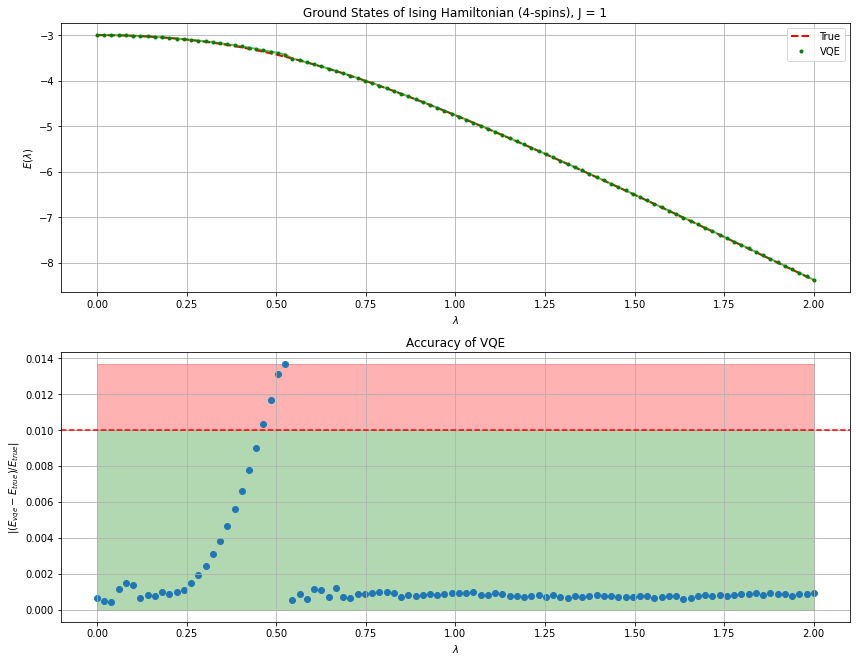

In [6]:
vqe.show_train_plots(data, N, J, vqe_cost_fn_mixed, 0)

In [7]:
@qml.qnode(dev_vqe_mixed)
def qcnn_circuit(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    qcnn.qcnn(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
    
    return qml.probs(wires = N - 1)

* 1. Split Test and Training set as 20-80 (This was not done randomly, the split was done so the test points are as sparse (and different) as possible)
* 2. We choose different sizes of the training set [npoints_list]
* 3. For npoints in npoints_list:
    * Draw randomly a subset of npoints from the training set
    * Train the QCNN just with those samples
    * Get the Loss and Accuracy on the Test Set
    * Get the mean and variance for the QCNNs trained with npoitns

In [42]:
def reduced_npoints_accuracies(data, npoints_list, n_iters, epochs, testdata_ratio = 0.2, plot = True):
    '''
    From the same VQE parameters we want to train many times a QCNN with different samples
    in order to find what is the average accuracy n-training points can reach
    '''
    # We need to declare this wrapper as global otherwise multiprocessing
    # does not work
    global wrapped_update
    
    # Array of indexes of test data
    test_idx = np.linspace(0, (len(data)-1), num = int(testdata_ratio*len(data)), dtype = int)
    X_test  = data[test_idx][:,0]
    Y_test  = data[test_idx][:,1]
    
    # The indexes in the training sets are the one not in the test set
    train_idx = []
    for i in range(len(data)):
        if i not in test_idx:
            train_idx.append(i)
    
    loss_means = []
    loss_devs  = []
    
    acc_means = []
    acc_devs  = []
    
    pbar = tqdm(total = len(npoints_list))
    
    for npoints in npoints_list:
        # Function for training a QCNN with multiprocessing
        def wrapped_update(idx):
            # Train a QCNN and save loss/accuracy for data-analysis
            
            # Force randomicity, multiprocessing tends to give the same random vectors
            # to each parallelized process
            np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
            
            # Choose a random subset of the training set of size npoints
            train_idx_it = np.random.choice(train_idx, npoints, replace=False)
            X_train = data[train_idx_it][:,0]
            Y_train = data[train_idx_it][:,1]
            
            # Train a QCNN with the random subset of the training set and get the parameters 
            _, _, params = qcnn.train(epochs, 0.05, 0.0008, 0, N, 0, 0, 0, 0,
                                                            qcnn_circuit, X_train, Y_train, plot = False, info = False)
            
            # Compute Accuracy and Loss on the test-set
            correctly_predicted = 0
            cross_entropy = 0
            for x,y in zip(X_test,Y_test):
                prediction = qcnn_circuit(x, shift_invariance, params, N)
            
                # Cross entropy rule
                cross_entropy += y * np.log(prediction[y]) + (1 - y) * np.log(1 - prediction[1 - y])
                
                # Accuracy
                if np.argmax( prediction ) == y:
                    correctly_predicted += 1  
                
            return cross_entropy, 100*correctly_predicted/len(Y_test)
        
        p = multiprocessing.Pool()
        with p: rdata = p.map(wrapped_update, np.arange(n_iters))
        
        rdata = np.array(rdata)
        
        loss_means.append(np.mean(rdata[:,0]))
        loss_devs.append(np.std(rdata[:,0]))
        acc_means.append(np.mean(rdata[:,1]))
        acc_devs.append(np.std(rdata[:,1]))
        
        pbar.update(1)
        
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(10,10))
            
        ax[0].plot(np.arange(len(npoints_list)), loss_means, color='indigo', lw = 2, alpha = 0.3)
        ax[0].errorbar(np.arange(len(npoints_list)), loss_means, yerr=3*np.array(loss_devs), fmt='o', color='indigo',
                       ecolor='blueviolet', elinewidth=3, capsize=0)
        ax[0].set_xticks(np.arange(len(npoints_list)))
        ax[0].set_xticklabels(npoints_list)
        ax[0].grid(True)
        ax[0].set_title('Losses on Test Set'.format(N,J))
        ax[0].set_xlabel('# points in Training Set')
        ax[0].set_ylabel('Cross-entropy')

        ax[1].plot(np.arange(len(npoints_list)), acc_means, color='red', ms = 7, alpha = 0.3)
        ax[1].errorbar(np.arange(len(npoints_list)), acc_means, yerr=3*np.array(acc_devs),fmt='o', color='red',
                       ecolor='red', elinewidth=3, capsize=0)
        ax[1].set_xticks(np.arange(len(npoints_list)))
        ax[1].set_xticklabels(npoints_list)
        ax[1].grid(True)
        ax[1].set_title('Accuracies on Test Set')
        ax[1].set_xlabel('# points in Training Set')
        ax[1].set_ylabel('(%)')
        
    return loss_means, loss_devs, acc_means, acc_devs

  0%|          | 0/7 [00:00<?, ?it/s]

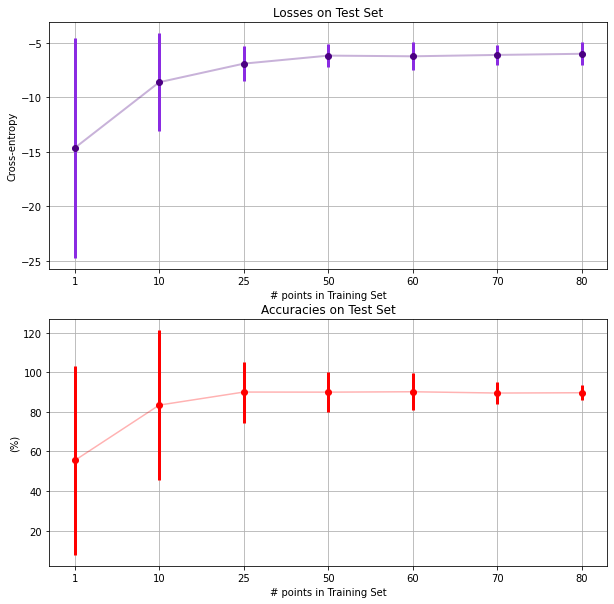

In [47]:
_ = reduced_npoints_accuracies(data, [1, 10, 25, 50, 60, 70, 80], 100, 150,
                               testdata_ratio = 0.2, plot = True)

In [ ]:
# Apparently our intuition is true and we do not need 80 samples